In [246]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [248]:
# Вспомогательная функция для вычисления метрик
def calculate_metrics(y_true, y_pred, model_name=""):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }
    
    print(f"\n{model_name}")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    
    return metrics

In [249]:
# Сигмоидальная функция активации и ее производная
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

In [250]:
# Класс одного нейрона
class Neuron:
    def __init__(self, n_inputs, lr=0.1):
        self.w = np.random.randn(n_inputs)
        self.b = 0.0
        self.lr = lr

    def forward(self, x):
        self.x = x
        self.z = np.dot(self.w, x) + self.b
        self.a = sigmoid(self.z)
        return self.a

    def backward(self, da):
        dz = da * sigmoid_derivative(self.z)
        dw = dz * self.x
        db = dz

        self.w -= self.lr * dw
        self.b -= self.lr * db

        return dz * self.w

In [252]:
# Класс слоя
class Layer:
    def __init__(self, n_inputs, n_neurons, lr=0.1):
        self.neurons = [Neuron(n_inputs, lr) for _ in range(n_neurons)]

    def forward(self, x):
        self.input = x
        self.output = np.array([n.forward(x) for n in self.neurons])
        return self.output

    def backward(self, dA):
        dX = np.zeros_like(self.input)
        for i, neuron in enumerate(self.neurons):
            dX += neuron.backward(dA[i])
        return dX

In [253]:
# Класс нейросети
# Нейросеть
class NeuralNetwork:
    def __init__(self, layers_sizes, lr=0.1):
        self.layers = []
        for i in range(len(layers_sizes) - 1):
            self.layers.append(
                Layer(layers_sizes[i], layers_sizes[i + 1], lr)
            )

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y_true):
        y_pred = self.layers[-1].output
        dA = y_pred - y_true  # MSE
        for layer in reversed(self.layers):
            dA = layer.backward(dA)

    def fit(self, X, y, epochs=1000):
        for _ in range(epochs):
            for xi, yi in zip(X, y):
                self.forward(xi)
                self.backward(yi)

    def predict(self, X):
        preds = []
        for x in X:
            out = self.forward(x)[0]
            preds.append(1 if out >= 0.5 else 0)
        return np.array(preds)

In [254]:
# Загрузка датасета и подготовка данных
iris = datasets.load_iris()
# Versicolor vs Virginica
mask = iris.target != 0
X = iris.data[mask][:, :2]
y_raw = iris.target[mask]
y = (y_raw == 2).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [272]:
# Обучение одного нейрона
single_neuron = Neuron(n_inputs=2, lr=0.05)

for epoch in range(1000):
    for xi, yi in zip(X_train, y_train):
        single_neuron.forward(xi)
        da = single_neuron.a - yi
        single_neuron.backward(da)

In [268]:
# Обучение нейросети
nn = NeuralNetwork([2, 10, 10, 1], lr=0.05)
nn.fit(X_train, y_train.reshape(-1, 1), epochs=5000)

In [273]:
# Предсказания
y_pred_neuron = []
for x in X_test:
    out = single_neuron.forward(x)
    y_pred_neuron.append(1 if out >= 0.5 else 0)

y_pred_neuron = np.array(y_pred_neuron)
y_pred_nn = nn.predict(X_test)

In [274]:
# Использование вспомогательной функции для метрик
metrics_neuron = calculate_metrics(y_test, y_pred_neuron, "ОДИН НЕЙРОН")
metrics_nn = calculate_metrics(y_test, y_pred_nn, "НЕЙРОСЕТЬ 2x10")


ОДИН НЕЙРОН
Accuracy: 0.5000
Precision: 0.4643
Recall: 1.0000
F1: 0.6341

НЕЙРОСЕТЬ 2x10
Accuracy: 0.7333
Precision: 0.6190
Recall: 1.0000
F1: 0.7647


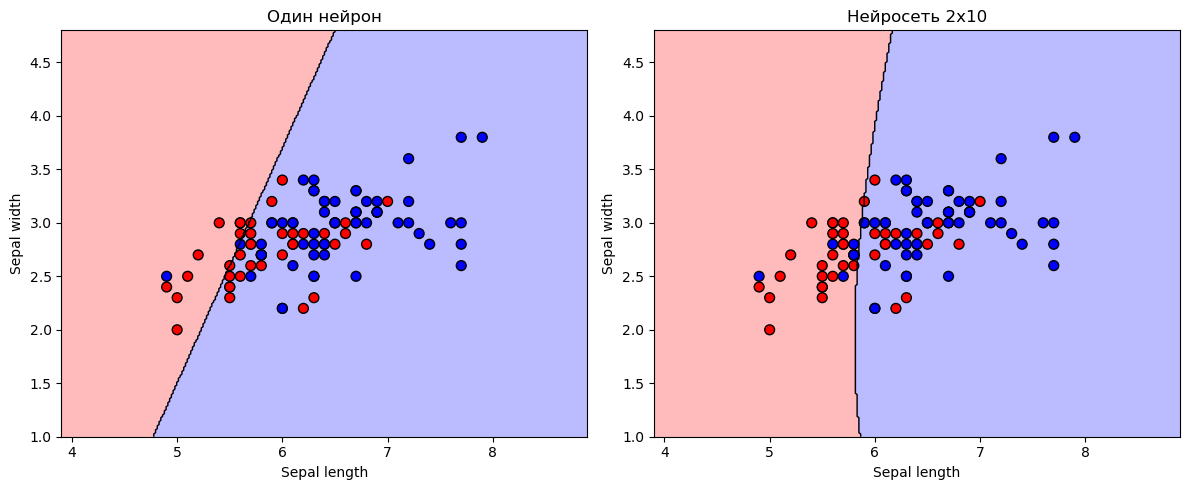

In [275]:
# Визуализация
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]

Z1 = []
for p in grid:
    Z1.append(1 if single_neuron.forward(p) >= 0.5 else 0)
Z1 = np.array(Z1).reshape(xx.shape)

Z2 = nn.predict(grid).reshape(xx.shape)

plt.figure(figsize=(12, 5))

# Создание цветовой карты для областей
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])  # Красный и синий для областей
cmap_bold = ['red', 'blue']  # Красные и синие шарики

plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z1, cmap=cmap_light, alpha=0.8)
plt.contour(xx, yy, Z1, colors='black', linewidths=1, levels=[0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(cmap_bold), 
            edgecolor='black', s=50)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title("Один нейрон")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z2, cmap=cmap_light, alpha=0.8)
plt.contour(xx, yy, Z2, colors='black', linewidths=1, levels=[0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(cmap_bold), 
            edgecolor='black', s=50)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title("Нейросеть 2x10")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.tight_layout()
plt.show()

Так как для обучения были выбраны виды Versicolor и Virginica - два типа ирисов, которые морфологически очень похожи друг на друга, их данные становятся сложно разделить линейно. Это объясняет проблемы у одного нейрона (линейного классификатора) - низкие показатели Accuracy (0.5000) и Precision (0.4643), что указывает на высокий процент ложноположительных срабатываний. Нейросеть же с архитектурой 2x10 демонстрирует существенно лучшие результаты по всем метрикам (Accuracy 0.7333, Precision 0.6190), что наглядно видно на графике: разделяющая линия у нейросети имеет более сложную, нелинейную форму, лучше соответствующую распределению данных в пространстве признаков.